In [3]:
%matplotlib inline

import neurolab as nl
import numpy as np
import matplotlib.pylab as pl

from neurolab.core import Net, Layer
from neurolab import init, layer

np.seterr(divide='ignore', invalid='ignore')

pl.style.use('ggplot')
pl.rcParams["figure.figsize"] = [12, 9]

In [42]:
def euclidean(A, B):
    return np.sqrt(np.sum(np.square(A - B), axis=1))


class RadBas:
    out_minmax = [0, 1]
    inp_active = [-5, 5]

    def __call__(self, x):
        return 1 / np.exp(x * x)


class RBN(Layer):
    def __init__(self, ci, cn):
        Layer.__init__(self, ci, cn, cn, {'w': (cn, ci), 'b': cn})

        self.transf = RadBas()
        self.out_minmax[:] = np.array([self.transf.out_minmax] * cn)
        self.s = np.zeros(self.cn)

    def _step(self, inp):
        self.s = euclidean(self.np['w'], inp.reshape([1, len(inp)]))
        self.s *= self.np['b']

        return self.transf(self.s)


class grnn_output_layer(Layer):
    """
    Linear/l2-norm Layer class

    :Parameters:
        ci: int
            Number of input
        cn: int
            Number of neurons
        transf: callable
            Transfer function
    """

    def __init__(self, ci, cn, transf):

        Layer.__init__(self, ci, cn, cn, {'w': (cn, ci), 'b': cn})

        self.transf = transf
        if not hasattr(transf, 'out_minmax'):
            test = np.asfarry([-1e100, -100, -10, -1, 0, 1, 10, 100, 1e100])
            val = self.transf(test)
            self.out_minmax = np.array([val.min(), val.max()] * self.co)
        else:
            self.out_minmax = np.asfarray([transf.out_minmax] * self.co)
        
        self.initf = init.initwb_reg
        
        self.s = np.zeros(self.cn)

    def _step(self, inp):
        
        self.s = np.sum(self.np['w'] * inp, axis=1)/np.sum(self.np['w'])
        self.s += self.np['b']
        return self.transf(self.s)


def newgrnn(minmax, cn0, cn1, bias):
    ci = len(minmax)
    
    layer_inp = RBN(ci, cn0)
    layer_out = grnn_output_layer(cn0, cn1, nl.net.trans.PureLin())
    
    layer_inp.np['b'].fill(bias)
    layer_inp.np['w'].fill(0.0)
    
    layer_out.np['w'].fill(0.0)
    
    net = Net(minmax, cn1, [layer_inp, layer_out], [[-1], [0], [1]], None, None)

    return net

In [43]:
n = 15

x = np.linspace(0, 5, n)
x = x.reshape(x.size, 1)

y = np.sin(x)
y = y.reshape(y.size, 1)

In [44]:
net = newgrnn(nl.tool.minmax(x), n, n, n)

net.layers[0].np['w'] = x

net.layers[1].np['w'] = y

In [45]:
xtest = np.linspace(0, 5, n)
xtest = xtest.reshape(xtest.size, 1)

out = net.sim(xtest).round(4)

/home/anton/v_envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


In [46]:
err = []

for i in out:
    err.append(np.sum(abs(i-y.round(4).reshape(1, len(y)))))

d_i = err.index(min(err))
print(min(err))

30.36


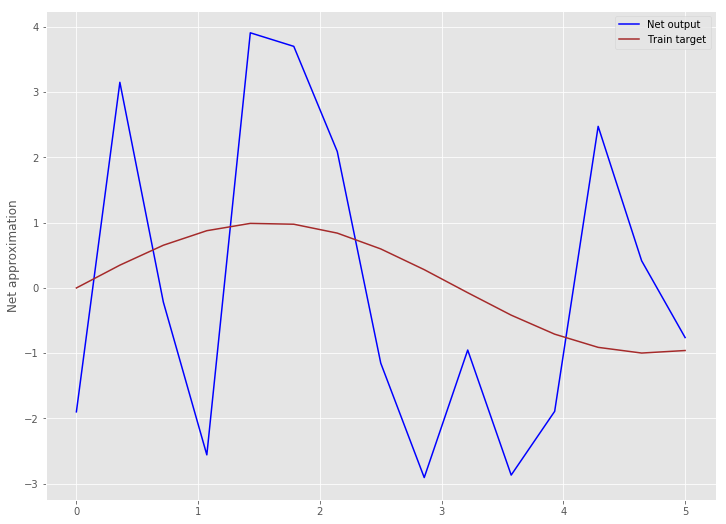

In [47]:
pl.plot(xtest, out[d_i], 'blue', x, y, 'brown')
pl.ylabel('Net approximation')
pl.legend(['Net output', 'Train target'])
pl.show()